## Loading the dataset

- 'transactions_train' is the main table, >31 million rows
- 'articles' and 'customers' are the side tables

In [4]:
import pandas as pd

In [16]:
articles = pd.read_csv('srcData/articles.csv', memory_map=True)
articles.index = articles['article_id']

In [ ]:

customers = pd.read_csv('srcData/customers.csv', memory_map=True)
customers.index = customers['customer_id']

The large table cannot fit inside the small memory of my VM. So I need to load it in smaller chunks that do fit 
inside memory.

Chunks of 0.1 million rows are a good size to read from CSV. Write the chunk out to a HDF file immediately, appending to any previous chunks.

In [ ]:
%%time

# https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-chunking
# this took <10 min and yields a 1GB hdf5 file

with pd.read_csv('srcData/transactions_train.csv', memory_map=True, iterator=True, chunksize=500000) as reader:
    i = 0
    for chunk in reader:
        # t = chunk.join(articles.iloc[:, 1:], 'article_id').join(customers.iloc[:, 1:], 'customer_id')
        chunk.to_hdf('data.hdf5', 'train', 'a', complevel=5, append=True, format='table')
        print(i)
        i += 1


---------------------------------------

## cluster the articles

In [6]:
articles.nunique(0)

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [13]:
# product_type_name, graphical_appearance_name, colour_group_name, perceived_colour_value_name, perceived_colour_master_name, 
# department_name, index_name, index_group_name, section_name, garment_group_name

for i in ['product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name',
'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']:
    print(articles.value_counts([i]))

product_type_name
Trousers             11169
Dress                10362
Sweater               9302
T-shirt               7904
Top                   4155
                     ...  
Bra extender             1
Blanket                  1
Towel                    1
Wood balls               1
Cushion                  1
Length: 131, dtype: int64
graphical_appearance_name
Solid                        49747
All over pattern             17165
Melange                       5938
Stripe                        4990
Denim                         4842
Front print                   3215
Placement print               3098
Check                         2178
Colour blocking               1830
Lace                          1513
Other structure               1502
Application/3D                1341
Embroidery                    1165
Mixed solid/pattern           1132
Glittering/Metallic            958
Jacquard                       830
Sequin                         806
Dot                            681
Tre

In [23]:
articles.loc[:, ['index_name', 'department_name', 'product_type_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'graphical_appearance_name']]

,index_name,department_name,product_type_name,perceived_colour_value_name,perceived_colour_master_name,graphical_appearance_name
article_id,,,,,,
108775015,Ladieswear,Jersey Basic,Vest top,Dark,Black,Solid
108775044,Ladieswear,Jersey Basic,Vest top,Light,White,Solid
108775051,Ladieswear,Jersey Basic,Vest top,Dusty Light,White,Stripe
110065001,Lingeries/Tights,Clean Lingerie,Bra,Dark,Black,Solid
110065002,Lingeries/Tights,Clean Lingerie,Bra,Light,White,Solid
...,...,...,...,...,...,...
953450001,Menswear,Socks Bin,Socks,Dark,Black,Placement print
953763001,Ladieswear,Jersey,Vest top,Dark,Black,Solid
956217002,Ladieswear,Jersey,Dress,Dark,Black,Solid


First, use one-hot encoding to convert the categorical variables to binary variables.

eg a column 'gender' with values 'M', 'F' becomes 2 columns 'M' and 'F' each with values '0' and '1'.

In [17]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
artcoded = onehot.fit_transform(articles.loc[:, ['index_name', 'department_name', 'product_type_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'graphical_appearance_name']])
# 449 columns

That resulted in an explosion of column count from 25 to 449.

We now need to compress the information in those 449 columns down to a smaller number, otherwise our model will be cursed by the high dimensionality.

We use TruncatedSVD to do dimensionality reduction, as it can handle sparse matrices.

We arbitrarily choose 80 as the target dimension. A better choice may be obtained by examining `tsvd.explained_variance_ratio_`.

In [18]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(80, n_iter=10, random_state=4129)
artfitted = tsvd.fit_transform(artcoded)

Now perform K-means clustering on the 80-dimensional matrix.

We assess the quality of the resulting clusters using the mean silhouette score. We need to repeat the K-means fitting for a range of values of K (`n_clusters`).

In [76]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# dbs = DBSCAN(n_jobs=-1)
# dbs.fit(artfitted)
# pd.Series(dbs.labels_).value_counts()

# returns the mean silhouette score
def do_kmeans(k, data):
    km = MiniBatchKMeans(k, random_state=4129)
    clust = km.fit_transform(data)
    return silhouette_score(clust, km.labels_)

artsamp = artfitted[np.random.choice(artfitted.shape[0], 10000, replace=False)]
# artsamp = artfitted.sample(frac=0.1, random_state=4129)
pd.DataFrame([(k, do_kmeans(k, artsamp)) for k in range(10, 51, 2)], columns=['k', 'silhouette'])

,k,silhouette
0,10,0.228222
1,12,0.225814
2,14,0.183626
3,16,0.159353
4,18,0.147717
5,20,0.152657
6,22,0.139844
7,24,0.132574
8,26,0.149277
9,28,0.118334


In [78]:
pd.DataFrame([(k, do_kmeans(k, artsamp)) for k in range(20, 31, 1)], columns=['k', 'silhouette'])

,k,silhouette
0,20,0.152657
1,21,0.152400
2,22,0.139844
3,23,0.138761
4,24,0.132574
5,25,0.134929
6,26,0.149277
7,27,0.128549
8,28,0.118334
9,29,0.117329


We decide on k=26 as this seems to give the highest silhouette score.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

km = KMeans(26, random_state=4129)
clust = km.fit_transform(artfitted)

pd.Series(km.labels_).value_counts()
sil = pd.DataFrame({"label":km.labels_, "silhouette":silhouette_samples(clust, km.labels_)})

In [20]:
# combined table
sil.groupby('label').mean().merge(sil.groupby('label').count(), left_index=True, right_index=True).set_axis(['silhouette','size'], axis=1).sort_values('silhouette', ascending=False)


,silhouette,size
label,,
23,0.408391,5827
9,0.365492,2073
19,0.341396,2528
10,0.314947,4313
1,0.289957,1502
17,0.254521,1860
20,0.243430,5718
15,0.240854,4152
3,0.234873,5930


About half of our clusters have silhouette scores 0.2-0.4. Six clusters have scores near 0.

Now add the cluster label to the original DataFrame, and save it into the HDF5 file for speedy retrieval next time.

In [21]:
articles['label'] = km.labels_
articles.to_hdf('data.hdf5', 'articles', 'a', complevel=5, append=False, format='table')

Examine what each cluster looks like.

For business analysis we would do this in loving detail. But not for ML/Kaggle...

In [42]:
articles.loc[:, ['label', 'index_name', 'department_name', 'product_type_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'graphical_appearance_name']][articles['label'] == 25]

,label,index_name,department_name,product_type_name,perceived_colour_value_name,perceived_colour_master_name,graphical_appearance_name
article_id,,,,,,,
163734054,25,Children Sizes 134-170,Young Girl Jersey Basic,Top,Light,Blue,Melange
194242049,25,Children Sizes 134-170,Young Girl Jersey Basic,Leggings/Tights,Dark,Grey,Melange
225784023,25,Children Sizes 134-170,Young Girl Jersey Basic,T-shirt,Bright,Pink,Stripe
225784037,25,Children Sizes 134-170,Young Girl Jersey Basic,T-shirt,Dark,Blue,Mixed solid/pattern
261840008,25,Children Sizes 134-170,Young Girl S&T,Socks,Dark,Black,Other pattern
...,...,...,...,...,...,...,...
935687001,25,Children Sizes 134-170,Young Boy Jersey Basic,Trousers,Dark,Blue,Colour blocking
936369001,25,Children Sizes 134-170,Young Boy Jersey Basic,Hoodie,Dark,Blue,Mixed solid/pattern
937280001,25,Children Sizes 134-170,Young Girl Jersey Fancy,T-shirt,Dark,Blue,All over pattern


Below code is scratch stuff

In [21]:
# manually compute the mean intra-cluster distance
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances, pairwise_distances_chunked

# mean intra-cluster distance
d = []
for n in dist.index:
    x = clust[km.labels_ == n, :]
    d.append(pairwise_distances(x, n_jobs=-1).mean())

dist['distsum'] = d
dist.columns = ['n', 'meandist']


       n  meandist
7  16468  0.608652
8  14107  0.693724
9  12403  0.675884
6  11926  0.713479
5  10370  0.607604
0   9587  0.668268
2   8667  0.696408
4   8285  0.795066
1   7046  0.909304
3   6683  0.759979
0.246902314113327


<AxesSubplot:xlabel='n'>

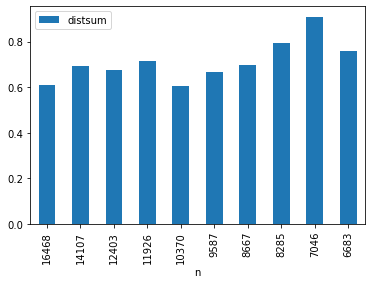

In [20]:
dist.plot(x='n', y='meandist', kind='bar')

## cluster the customers

---------------------------------------

## partition the dataset

Extract 1 million rows as train, and the following 100k rows as test.

Then add the article cluster label.

In [5]:
# seek to a random row in the hdf5 file is very fast

articles = pd.read_hdf('data.hdf5', 'articles')
t = pd.read_hdf('data.hdf5', 'train', start=30000000, stop=31100000)
# t = pd.read_hdf('data.hdf5', 'train', columns=['t_dat'], start=000000, stop=1000000)

t = t.join(articles['label'], on='article_id')
train, test = t[:1000000], t[1000000:]
del t

In [6]:
test = pd.concat((train[train['t_dat'] == '2020-09-01'], test))
train = train[train['t_dat'] < '2020-09-01'][train['t_dat'] > '2020-08-06']

/tmp/ipykernel_7875/1266200805.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[train['t_dat'] < '2020-09-01'][train['t_dat'] > '2020-08-06']


The training set contains rows from 2020-08-07 to 2020-08-31.  
The test set contains rows from 2020-09-01 to 2020-09-03.

In [7]:
train['t_dat'].min(), train['t_dat'].max(),

('2020-08-07', '2020-08-31')

In [8]:
test['t_dat'].min(), test['t_dat'].max()
# train.shape, test.shape

('2020-09-01', '2020-09-03')

In [16]:
print('count\n', train.count())
print('nunique\n', train.nunique())
x = train.loc[:, ['customer_id','article_id','label']].groupby('customer_id').nunique()
print('article per customer\n', x['article_id'].describe())
print('label per customer\n', x['label'].describe())

count
 t_dat               950500
customer_id         950500
article_id          950500
price               950500
sales_channel_id    950500
label               735753
dtype: int64
nunique
 t_dat                   25
customer_id         210665
article_id           28277
price                 4202
sales_channel_id         2
label                   26
dtype: int64
article per customer
 count    210665.000000
mean          4.004956
std           3.941590
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         102.000000
Name: article_id, dtype: float64
label per customer
 count    210665.000000
mean          2.356889
std           1.920949
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          23.000000
Name: label, dtype: float64
